In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import cv2
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches
from pathlib import Path
import sys
sys.path.append("/home/psa_images/SemiF-AnnotationPipeline")
sys.path.append("/home/psa_images/SemiF-AnnotationPipeline/segment")
from semif_utils.utils import cutoutmeta2csv
from semif_utils.utils import apply_mask
import json

/home/mkutuga/anaconda3/envs/semif/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_metadata(path):
    with open(path, 'r') as f:
        data = json.loads(f.read())
    return data

def get_detection_data(jsonpath):
    meta = read_metadata(jsonpath)
    imgwidth, imgheight = meta['width'], meta['height']
    bboxes = meta["bboxes"]
    boxes = []
    labels = []
    for box in bboxes:
        
        # top_left = box["local_coordinates"]["top_left"]
        # bottom_right = box["local_coordinates"]["bottom_right"]
        
        # print(box["local_coordinates"].keys())
        x1 = box["local_coordinates"]["top_left"][0] # * 9560
        y1 = box["local_coordinates"]["top_left"][1] # * 6368
        
        x2 = box["local_coordinates"]["bottom_right"][0] # * 9560
        y2 = box["local_coordinates"]["bottom_right"][1] # * 6368
        
        # xywh = box["local_coordinates"]["xywh"]
        # w = xywh[2] * imgwidth
        # h = xywh[3] * imgheight
        # x1 = xywh[0] * imgwidth - w/2
        # y1 = xywh[1] * imgheight - h/2
        # x2 = x1 + w
        # y2 = y1 + h
        
        # x1, y1 = int(top_left[0]*imgwidth), int(top_left[1]*imgheight)
        # x2, y2 = int(bottom_right[0]*imgwidth), int(bottom_right[1]*imgheight)
        # print([x1, y1, x2, y2])
        boxes.append([x1, y1, x2, y2])
        if box["cls"] == "plant":
            class_id = box["cls"]
            common_name = box["cls"]
        else:
            class_id = str(box["cls"]["class_id"])
            common_name = box["cls"]["common_name"]

        label =  f"{common_name} ({class_id})"
        labels.append(label)

    return boxes, labels

def batch_df(df, batch_id, cutout_dir, batch_dir):
    df = pd.read_csv(Path(cutout_dir, batch_id, batch_id + ".csv"))
    df["state_id"] = df.batch_id.str.split("_", expand=False).str[0]
    df["date"] = df.batch_id.str.split("_", expand=False).str[1]
    df["cutout_paths"] = cutout_dir + "/" + batch_id + "/" + df["cutout_id"] + ".png"
    df["image_paths"] = batch_dir + "/images/" + df["image_id"] + ".jpg"
    df["meta_paths"] = batch_dir + "/metadata/" + df["image_id"] + ".json"
    df["semantic_masks"] = batch_dir + "/meta_masks/semantic_masks/" + df["image_id"] + ".png"
    df["instance_masks"] = batch_dir + "/meta_masks/instance_masks/" + df["image_id"] + ".png"
    return df

def review_data(df, batch_id):
    print("\nBatch: ", batch_id)
    print("\nTotal number of cutouts by species")
    print(df.groupby(["common_name"])["cutout_id"].nunique())
    print(len(df))



In [3]:
cutout_dir = Path( "/mnt/research-projects/s/screberg/longterm_images/semifield-cutouts")
batch_dir = Path("/mnt/research-projects/s/screberg/longterm_images/semifield-developed-images")
species_info = Path("/home/psa_images/SemiF-AnnotationPipeline/data/semifield-utils/species_information/species_info.json")

cutout_batches = [x.stem for x in cutout_dir.glob("*")]
project_bathces =  [x.stem for x in batch_dir.glob("*")]
common_batches = list(set(cutout_batches).intersection(project_bathces))
uncommon_batches = list(set(cutout_batches).symmetric_difference(project_bathces))

## Check cutouts json data schema from Summer Weeds 2022 and Cover crops 2023

In [4]:
data = [{"state": x.split("_")[0], "date":x.split("_")[-1]} for x in common_batches]
sorted_data = sorted(data, key=lambda x: x['date'])
common_batches = [x["state"] + "_" + x["date"] for x in sorted_data]

In [5]:
first = common_batches[2]
last = common_batches[-1]
print(first, last)
print()
compared_batches = [first, last]
compared_batches

keys = []
cls_keys = []
props = []
dict_keys = []

for batch in compared_batches:
    metadata = [x for x in Path(cutout_dir, batch).glob("*.json")][:50]
    for meta in metadata:
        data = read_metadata(meta)
        keys.append(data.keys())
        cls_keys.append(data["cls"].keys())
        props.append(data["cutout_props"].keys())
        for key, value in data.items():
            if type(value) is dict:
                dict_keys.append(key)


MD_2022-06-27 TX_2023-05-20



In [6]:
weed_batches = [x for x in  Path(cutout_dir, compared_batches[0]).glob("*.json")]
cover_batches = [x for x in Path(cutout_dir, compared_batches[-1]).glob("*.json")]

weeds = read_metadata(weed_batches[0])
ccs = read_metadata(cover_batches[0])

## Get species info data

In [7]:
spec_info = read_metadata(species_info)
usda_symbols = list(spec_info["species"])
# for idx, i in spec_info["species"].items():
    # print(i["category"])

# Weeds 2022/2023

In [46]:
# Create dictionary
weeds = read_metadata(weed_batches[0])

## Remove from Weeds

In [47]:
## first level keys
# remove DAP
if "blob_home" in weeds:
    weeds.pop("blob_home")
if "dap" in weeds:
    weeds.pop("dap")
# remove local contours
if "local_contours" in weeds:
    weeds.pop("local_contours")
# remove cutout version
if "cutout_version" in weeds:
    weeds.pop("cutout_version")

## Cls
# remove collection location in cls
if "collection_location" in weeds["cls"]:
    weeds["cls"].pop("collection_location")

# # remove category in cls
# if "category" in weeds["cls"]:
#     weeds["cls"].pop("category")
# # remove collection timing in cls
# if "collection_timing" in weeds["cls"]:
#     weeds["cls"].pop("collection_timing")


## Cutout Properties
# remove area_bbox
if "area_bbox" in weeds["cutout_props"]:
    weeds["cutout_props"].pop("area_bbox")
# remvoe area_convex
if "area_convex" in weeds["cutout_props"]:
    weeds["cutout_props"].pop("area_convex")
# remove extent
if "extent" in weeds["cutout_props"]:
    weeds["cutout_props"].pop("extent")
# Remove is green
if "is_green" in weeds["cutout_props"]:
    weeds["cutout_props"].pop("is_green")
# remove exg_sum
if "exg_sum" in weeds["cutout_props"]:
    weeds["cutout_props"].pop("exg_sum")
# remove color_distribtution
if "color_distribution" in weeds["cutout_props"]:
    weeds["cutout_props"].pop("color_distribution")
# remove descriptive stats
if "descriptive_stats" in weeds["cutout_props"]:
    weeds["cutout_props"].pop("descriptive_stats")



# Get missing info 
1. descriptive stats for cutout
2. descriptive stats for cropout
3. bbox (weeds do not have mappable bbox coordinates)
4. hwc
5. season

In [48]:
from scipy import stats

def descriptive_stats(rgb_img, ignore_zeros=False):

    rgb_img = rgb_img.astype(np.float64)

    if ignore_zeros:
        #     # Mask out zero values for descriptive stats
        rgb_img[rgb_img == [0, 0, 0]] = np.nan

    rgb_channels = cv2.split(rgb_img)
    str_channels = ["r", "g", "b"]
    desc_stats = dict()
    for img_c, str_c in zip(rgb_channels, str_channels):
        rec_key = f"channel_{str_c}"
        # dataframe describe automatically ignores nans
        c_df = pd.DataFrame(img_c.flatten(), columns=[rec_key]).describe()
        # scipy describe stats ignore nans
        c_scipy_desc = stats.describe(img_c.flatten(), nan_policy='omit')
        c_df.loc["variance"] = c_scipy_desc.variance
        c_df.loc["skewness"] = c_scipy_desc.skewness
        c_df.loc["kurtosis"] = c_scipy_desc.kurtosis
        desc_stats.update(c_df.to_dict())

    return desc_stats



cropout_path = str(Path(cutout_dir, weeds["cutout_path"])).replace("png", "jpg")
cropout_rgb_img = cv2.cvtColor(cv2.imread(str(cropout_path)), cv2.COLOR_BGR2RGB)

cutout_path = str(Path(cutout_dir, weeds["cutout_path"]))
cutout_rgb_img = cv2.cvtColor(cv2.imread(str(cutout_path)), cv2.COLOR_BGR2RGB)

# Descriptive stats for cutout and cropout
crop_out_desc_stats = descriptive_stats(cropout_rgb_img)
cutout_desc_stats = descriptive_stats(cutout_rgb_img, ignore_zeros=True)

# hwc
hwc = cutout_rgb_img.shape

# season TODO: make this so its not always the weeds variable
category = weeds["cls"]["category"] 
if category == "warm season weed":
    season = "summer_weeds_2022"
elif category == "cool season cover crop":
    season = "cool_season_covers_2022_2023"


## Get bbox info

In [166]:
if season == "cool_season_covers_2022_2023":
    # bbox (can only be applied to covers)
    meta_fname = ccs["image_id"] + ".json"
    image_metadata_path = str(Path(batch_dir, ccs["batch_id"], "metadata",meta_fname))
    image_meta = read_metadata(image_metadata_path)
    bbox_id = ccs["cutout_id"]
    bbox = [x for x in image_meta["bboxes"] if x["bbox_id"] == bbox_id][0]
    bbox['local_coordinates'].pop('is_scaleable')
    omit_keys = ['bbox_id','image_id', 'cls', 'is_primary', 'global_centroid', 'global_coordinates', 'instance_id']
    new_bbox = create_dict_with_omitted_keys(bbox, omit_keys)

## Include in Weeds 2022

In [171]:
## TODO: find date when seasons begin and end
## TODO find all season names
# include season
if "season" not in weeds:
    weeds["season"] = "summer_weeds_2022"

# add bbox
if "bbox" not in weeds:
    weeds["bbox"] = None

# add multispecies_USDA_symbol
if "multi_species_USDA_symbol" not in weeds["cls"]:
    weeds["cls"]["multi_species_USDA_symbol"] = None

# add hwc
if "hwc" not in weeds or "hwc" not in weeds["cutout_props"]:
    weeds["hwc"] = hwc
    
# replace shape with hwc for covers
if "hwc" not in weeds and "shape" in weeds:
    weeds["hwc"] = weeds["shape"]
    weeds.pop("shape")

# add cropout descriptive stats
if "cropout_descriptive_stats" not in weeds["cutout_props"]:
    weeds["cutout_props"]["cropout_descriptive_stats"] = crop_out_desc_stats

# add cutout descriptive stats
if "cutout_descriptive_stats" not in weeds["cutout_props"]:
    weeds["cutout_props"]["cutout_descriptive_stats"] = cutout_desc_stats


# Cover Crops 2022/2023

In [172]:
# Create dictionary
ccs = read_metadata(cover_batches[0])

## Remove from Covers 2022/23

In [27]:
## First level 
# remove Blob home
if "blob_home" in ccs:
    ccs.pop("blob_home")

## Cls
# remove collection location in cls
if "collection_location" in ccs["cls"]:
    ccs["cls"].pop("collection_location")

# # remove category in cls
# if "category" in ccs["cls"]:
#     ccs["cls"].pop("category")
# # remove collection timing in cls
# if "collection_timing" in ccs["cls"]:
#     ccs["cls"].pop("collection_timing")

## Cutout properties
# remove area_bbox
if "area_bbox" in ccs["cutout_props"]:
    ccs["cutout_props"].pop("area_bbox")
# remove area_convex
if "area_convex" in ccs["cutout_props"]:
    ccs["cutout_props"].pop("area_convex")
# remove cutout version
if "cutout_version" in ccs:
    ccs.pop("cutout_version")


## Include from Covers 2022/2023

In [28]:
# replace shape with hwc or add it
if "shape" in ccs:
    ccs["hwc"] = ccs["shape"]
    ccs.pop("shape")
else:
    ccs["hwc"] = None

# Order dictionaries

In [34]:
def order_dict_by_list(original_dict, order_list, value_order_lists):
    ordered_dict = dict()

    for key in order_list:
        if key in original_dict:
            value = original_dict[key]
            if isinstance(value, dict):
                ordered_dict[key] = order_dict_by_list(value, order_list, value_order_lists)
            else:
                ordered_dict[key] = value

    for key in original_dict:
        if key not in order_list:
            value = original_dict[key]
            if isinstance(value, dict):
                ordered_dict[key] = order_dict_by_list(value, order_list, value_order_lists)
            else:
                ordered_dict[key] = value

    ordered_second_levels = dict()
    for key in ordered_dict:
        value = ordered_dict[key]
        if isinstance(value, dict):
            if key in value_order_lists:
                ordered_second_levels[key] = dict(
                    sorted(value.items(), key=lambda x: value_order_lists[key].index(x[0]))
                )
            else:
                ordered_second_levels[key] = value

    ordered_dict.update(ordered_second_levels)

    return ordered_dict

ccs_cutout_key_list = ['data_root','batch_id', 'image_id', 'cutout_id', 'cutout_num', 'cutout_path','datetime', 'season', 'bbox', 'is_primary', 'extends_border', 'hwc', 'cls', 'cutout_props']
ccs_cut_cls_key_list = ['class_id', 'USDA_symbol', 'EPPO', 'group', 'class', 'subclass', 'order', 'family', 'genus', 'species', 'common_name', 'authority', 'growth_habit', 'duration', 'multi_species_USDA_symbol', 'link', 'note', 'hex', 'rgb']
ccs_cut_props_key_list = ['area', 'axis_major_length', 'axis_minor_length', 'centroid0', 'centroid1', 'eccentricity', 'solidity', 'perimeter', 'green_sum', 'blur_effect', 'num_components', 'cropout_descriptive_stats', 'cutout_descriptive_stats']

order_list =ccs_cutout_key_list
value_order_lists = {
    'cls': ccs_cut_cls_key_list,
    'cutout_props': ccs_cut_props_key_list
}

weeds = order_dict_by_list(weeds, order_list, value_order_lists)
ccs = order_dict_by_list(ccs, order_list, value_order_lists)

# Compare Weeds and Cover metadata

In [35]:
print(set(weeds.keys()) == set(ccs.keys()))
print(weeds.keys())
print(ccs.keys())

print()
print(set(weeds["cls"].keys()) == set(ccs["cls"].keys()))
print(weeds["cls"].keys())
print(ccs["cls"].keys())

print()
print(set(weeds["cutout_props"].keys()) == set(ccs["cutout_props"].keys()))
print(weeds["cutout_props"].keys())
print(ccs["cutout_props"].keys())

True
dict_keys(['data_root', 'batch_id', 'image_id', 'cutout_id', 'cutout_num', 'cutout_path', 'datetime', 'season', 'bbox', 'is_primary', 'extends_border', 'hwc', 'cls', 'cutout_props', 'schema_version'])
dict_keys(['data_root', 'batch_id', 'image_id', 'cutout_id', 'cutout_num', 'cutout_path', 'datetime', 'season', 'bbox', 'is_primary', 'extends_border', 'hwc', 'cls', 'cutout_props', 'schema_version'])

True
dict_keys(['class_id', 'USDA_symbol', 'EPPO', 'group', 'class', 'subclass', 'order', 'family', 'genus', 'species', 'common_name', 'authority', 'growth_habit', 'duration', 'multi_species_USDA_symbol', 'link', 'note', 'hex', 'rgb'])
dict_keys(['class_id', 'USDA_symbol', 'EPPO', 'group', 'class', 'subclass', 'order', 'family', 'genus', 'species', 'common_name', 'authority', 'growth_habit', 'duration', 'multi_species_USDA_symbol', 'link', 'note', 'hex', 'rgb'])

True
dict_keys(['area', 'axis_major_length', 'axis_minor_length', 'centroid0', 'centroid1', 'eccentricity', 'solidity', 'per

# Get descriptive stats for cropout

# Get missing Bbox info

# Get missing HWC info

# Save sample json

In [32]:
with open('weeds2022_examples.json', 'w') as fp:
    json.dump(weeds, fp)

with open('covers2023_examples.json', 'w') as fp:
    json.dump(ccs, fp)

In [8]:
from collections import OrderedDict

def order_dict_by_list(original_dict, order_list, value_order_lists):
    ordered_dict = dict()

    for key in order_list:
        if key in original_dict:
            value = original_dict[key]
            if isinstance(value, dict):
                ordered_dict[key] = order_dict_by_list(value, order_list, value_order_lists)
            else:
                ordered_dict[key] = value

    for key in original_dict:
        if key not in order_list:
            value = original_dict[key]
            if isinstance(value, dict):
                ordered_dict[key] = order_dict_by_list(value, order_list, value_order_lists)
            else:
                ordered_dict[key] = value

    ordered_second_levels = dict()
    for key in ordered_dict:
        value = ordered_dict[key]
        if isinstance(value, dict):
            if key in value_order_lists:
                ordered_second_levels[key] = dict(
                    (k, value[k]) for k in value_order_lists[key] if k in value
                )
            else:
                ordered_second_levels[key] = value

    ordered_dict.update(ordered_second_levels)

    return ordered_dict

# Example usage
original_dict = {
    'd':1,
    'b': {
        'x': 1,
        'y': 2,
        'z': 3,
        'a':1
    },
    'a': {
        'z': 4,
        'y': 5,
        'x': 6
    },
    'c': {
        'x': 7,
        'z': 8,
        'y': 9
    }
}

order_list = ['b', 'a', 'c']
value_order_lists = {
    'b': ['z', 'x', 'y','a'],
    'c': ['y', 'x', 'z','a'],
    'd': ['w', 'x', 'y', 'z']
}

ordered_dict = order_dict_by_list(original_dict, order_list, value_order_lists)
print(ordered_dict)

{'b': {'z': 3, 'x': 1, 'y': 2, 'a': 1}, 'a': {'z': 4, 'y': 5, 'x': 6}, 'c': {'y': 9, 'x': 7, 'z': 8}, 'd': 1}


In [37]:
from collections import OrderedDict

def order_dict_by_list(original_dict, order_list, value_order_lists):
    ordered_dict = dict()

    for key in order_list:
        if key in original_dict:
            value = original_dict[key]
            if isinstance(value, dict):
                ordered_dict[key] = order_dict_by_list(value, order_list, value_order_lists)
            else:
                ordered_dict[key] = value

    ordered_second_levels = dict()
    for key in value_order_lists:
        if key in original_dict:
            value = original_dict[key]
            if isinstance(value, dict):
                ordered_second_levels[key] = dict(
                    (k, value[k]) for k in value_order_lists[key] if k in value
                )

    ordered_dict.update(ordered_second_levels)

    return ordered_dict

# Example usage
original_dict = {
    'zzz':100000,
    'b': {
        'x': 1,
        'y': 2,
        'z': 3
    },
    'a': {
        'z': 4,
        'y': 5,
        'x': 6
    },
    'c': {
        'x': 7,
        'z': 8,
        'y': 9,
        'zzzzzz':1000000
    }
}

order_list = ['c', 'a', 'b']
value_order_lists = {
    'a':['xa'],
    'b': ['z', 'x', 'y'],
    'c': ['y', 'x', 'z'],
    'd': ['w', 'x', 'y', 'z']
}

ordered_dict = order_dict_by_list(original_dict, order_list, value_order_lists)
print(ordered_dict)


{'c': {'y': 9, 'x': 7, 'z': 8}, 'a': {}, 'b': {'z': 3, 'x': 1, 'y': 2}}


channel_r:
mean: 33.13241977963219
std: 72.20030848439804

channel_g:
mean: 34.291694397515315
std: 68.96088419941869

channel_b:
mean: 10.321268281028686
std: 24.136421045357242



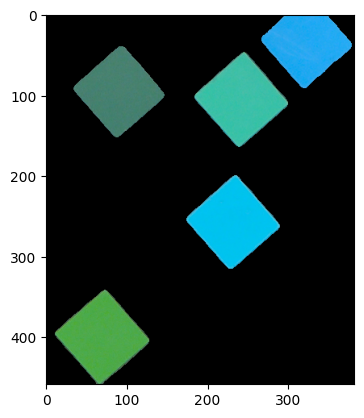

In [33]:
import cv2
import numpy as np
from scipy.stats import skew, kurtosis

def analyze_image(image_path, exclude_black=True):
    # Load the image
    image = cv2.imread(image_path)

    # Split the image into individual channels
    b, g, r = cv2.split(image)

    # Create a mask to identify non-black pixels
    mask = None
    if exclude_black:
        mask = cv2.bitwise_or(cv2.bitwise_or(b, g), r)

    # Calculate the mean, count, standard deviation, minimum, and maximum values for each channel
    # Calculate the mean and standard deviation for each channel
    b_mean, b_std = cv2.meanStdDev(b, mask=mask)
    g_mean, g_std = cv2.meanStdDev(g, mask=mask)
    r_mean, r_std = cv2.meanStdDev(r, mask=mask)

    # Calculate the count of pixels based on exclusion/inclusion of black pixels
    b_count = np.count_nonzero(b) if exclude_black else b.size
    g_count = np.count_nonzero(g) if exclude_black else g.size
    r_count = np.count_nonzero(r) if exclude_black else r.size

    b_skewness = skew(b[np.nonzero(b)]) if exclude_black else skew(b.flatten())
    g_skewness = skew(g[np.nonzero(g)]) if exclude_black else skew(g.flatten())
    r_skewness = skew(r[np.nonzero(r)]) if exclude_black else skew(r.flatten())

    b_kurtosis = kurtosis(b[np.nonzero(b)]) if exclude_black else kurtosis(b.flatten())
    g_kurtosis = kurtosis(g[np.nonzero(g)]) if exclude_black else kurtosis(g.flatten())
    r_kurtosis = kurtosis(r[np.nonzero(r)]) if exclude_black else kurtosis(r.flatten())

    b_variance = np.var(b[np.nonzero(b)]) if exclude_black else np.var(b.flatten())
    g_variance = np.var(g[np.nonzero(g)]) if exclude_black else np.var(g.flatten())
    r_variance = np.var(r[np.nonzero(r)]) if exclude_black else np.var(r.flatten())


    # Calculate the minimum and maximum values for each channel
    b_min = np.min(b[np.nonzero(b)]) if exclude_black else np.min(b)
    g_min = np.min(g[np.nonzero(g)]) if exclude_black else np.min(g)
    r_min = np.min(r[np.nonzero(r)]) if exclude_black else np.min(r)
    b_max = np.max(b)
    g_max = np.max(g)
    r_max = np.max(r)

    # Return the results as a dictionary
    result = {
        
        'channel_r': {
            'mean': r_mean[0][0],
            # 'count': r_count,
            'std': r_std[0][0],
            # 'skewness': r_skewness,
            # 'kurtosis': r_kurtosis,
            # 'variance': r_variance,
            # 'min': r_min,
            # 'max': r_max
        },
        'channel_g': {
            'mean': g_mean[0][0],
            # 'count': g_count,
            'std': g_std[0][0],
            # 'skewness': g_skewness,
            # 'kurtosis': g_kurtosis,
            # 'variance': g_variance,
            # 'min': g_min,
            # 'max': g_max
        },
        'channel_b': {
            'mean': b_mean[0][0],
            # 'count': b_count,
            'std': b_std[0][0],
            # 'skewness': b_skewness,
            # 'kurtosis': b_kurtosis,
            # 'variance': b_variance,
            # 'min': b_min,
            # 'max': b_max
        }
        
    }

    return result, mask,image

# Usage example
# image_path = str(Path(cutout_dir, weeds["cutout_path"]))#.replace("png", "jpg")
image_path = str(Path(cutout_dir, "TX_2023-05-20/TX_1684590709_0.png"))#.replace("png", "jpg")

# image_path = str(Path(cutout_dir, weeds["cutout_path"]))

result, mask,image= analyze_image(image_path, exclude_black=False)

# Print the results
for channel, values in result.items():
    print(channel + ':')
    
    for metric, value in values.items():
        print(metric + ':', value)

    print()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

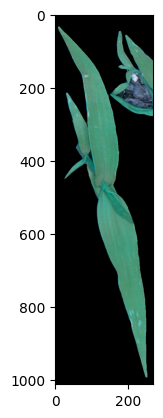

In [27]:
# image[image == [0, 0, 0]] = np.nan
plt.imshow(image)

image